In [58]:
import os
import glob
import ROOT
import mplhep as hep
import os
import numpy as np
import matplotlib.pyplot as plt
# TODO: Convert from ROOT object to numpy arrays for plotting, to avoid ANNOYING BUG IN PYROOT
hep.style.use(hep.style.CMS)
# Set latex font
# plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams.update({'font.size': 16})
ROOT.gROOT.SetBatch(True)

# Use numpy-backed histogram wrapper (replaces direct ROOT.TH1 usage downstream)
from numpy_hist import NumpyHist1D, NumpyHist2D


def find_histogram_names(all_names, keyword, only_one=True):
    # Helper function to find the histogram names containing the keyword
    # e.g., target = '04_MET_e_dphi_h_e_pt', keyword = 'MET_e_dphi' (cut name) + '_h_e_pt' (variable name)
    matched = [name for name in all_names if keyword in name]
    if only_one:
        if len(matched) == 1:
            return matched[0]
        else:
            raise ValueError(f"Expected exactly one match for keyword '{keyword}', found {len(matched)}.")
    return matched


def read_root_histograms(outdir="outdir", pattern="*.root", blacklist=[]):
    """
    Read all .root files matching outdir/pattern and return a dict:
    {
      'file_base_name': {
         'histname': NumpyHist1D/2D object (detached from file),
         ...
      },
      ...
    }
    Only top-level histograms are read (no recursion into subdirectories).
    Histograms are converted to numpy-backed objects so they remain alive after file close
    and support a ROOT-like API (Scale, Rebin, GetXaxis, etc.).
    """
    result = {}
    print('DEBUG', flush=True)
    paths = sorted(glob.glob(os.path.join(outdir, pattern)))
    print(f"Found {len(paths)} ROOT files matching pattern '{pattern}' in '{outdir}'.")
    for path in paths:
        print(path, flush=True)
        if any(bl_item in path for bl_item in blacklist):
            continue
        fname = os.path.splitext(os.path.basename(path))[0]
        f = ROOT.TFile.Open(path, "READ")
        if not f or f.IsZombie():
            if f:
                f.Close()
            continue
        result[fname] = {}
        keys = f.GetListOfKeys()
        if not keys:
            f.Close()
            continue
        for key in keys:
            obj = key.ReadObj()
            if not obj:
                continue
            # IMPORTANT: check TH2 before TH1 since TH2 inherits from TH1
            if obj.InheritsFrom("TH2"):
                try:
                    h = NumpyHist2D.from_root_th2(obj)
                except Exception as e:
                    print(f"Warning: failed to convert 2D histogram '{obj.GetName()}': {e}")
                    continue
                result[fname][obj.GetName()] = h
            elif obj.InheritsFrom("TH1"):
                # Convert to numpy-backed 1D histogram wrapper
                try:
                    h = NumpyHist1D.from_root_th1(obj)
                except Exception as e:
                    print(f"Warning: failed to convert histogram '{obj.GetName()}': {e}")
                    continue
                result[fname][obj.GetName()] = h

        f.Close()
    return result


def rebinning_histogram(hist, rebin_factor):
    """
    Rebin a histogram by the given rebin_factor.
    Returns a new histogram object.
    rebin_factor defines how many original bins are merged into one.
    For 2D histograms, provide either an int (applied to both axes) or a tuple (fx, fy).
    """
    if isinstance(rebin_factor, (list, tuple, np.ndarray)):
        rf_is_one = all(int(x) <= 1 for x in rebin_factor)
    else:
        rf_is_one = int(rebin_factor) <= 1
    if rf_is_one:
        return hist.Clone()  # No rebinning needed

    # Clone the original histogram to create a new one, then rebin in-place on the clone
    rebinned_hist = hist.Clone()
    rebinned_hist.Rebin(rebin_factor)
    return rebinned_hist


def apply_weights(hist_dict, cross_sections, target_lumi):
    for proc_name, histograms in hist_dict.items():
        if proc_name not in cross_sections:
            continue
        xsec = cross_sections[proc_name]  # in pb

        # Count total events in the histogram from '00_Initial_n_muons'
        initial_hist = histograms.get('00_Initial_n_muons', None)
        # last_hist = histograms.get('03_MET_dphi_n_muons', None)
        last_hist = histograms.get(find_histogram_names(all_hist_lists, 'finalstate_nocut_m_collinear', only_one=True), None)
        if initial_hist is None:
            continue
        # Total event = number of entries in the histogram
        # total_events = initial_hist.Integral() # ARE YOU DUMP???, not GetEntries()
        total_events = initial_hist.GetEntries()
        if total_events == 0:
            continue
        weight = (xsec * target_lumi) / total_events
        passed_events = last_hist.GetEntries() if last_hist else 0
        efficiency = passed_events / total_events if total_events > 0 else 0
        total_yield = passed_events * weight
        print(f"Process: {proc_name}, Weight: {weight}, Total Events: {total_events}, XSec: {xsec} pb, Efficiency: {efficiency}, Total Yield: {total_yield}")
        # Apply weight to all histograms of this process
        for hname, hist in histograms.items():
            hist.Scale(weight)


def plot_target_histogram(signal, background, histname,
                          custom_parameters={},
                          outdir="prefit_histograms",
                          saveas_pdf=False,
                          save_name="histogram_plot",
                          lumi_label="1 ab$^{-1}$ ($\\sqrt{s} = 240$ GeV)",
                          process_colours=None,
                          process_propernames=None,
                          figsize=(10,6)):
    """
    Plot one target histogram `histname` given:
      - signal:    {'signal_file': {'histname': TH1/TH2-like, ...}, ...}
      - background:{'bkg_file':    {'histname': TH1/TH2-like, ...}, ...}
    Produces a stacked background and overlaid signal(s). Handles absent inputs.
    (This function expects 1D histograms for plotting; 2D histograms should be handled elsewhere.)
    """

    custom_title = custom_parameters.get('title', None)
    custom_xlabel = custom_parameters.get('xlabel', None)
    custom_ylabel = custom_parameters.get('ylabel', None)
    yscale = custom_parameters.get('yscale', 'linear')
    xlim = custom_parameters.get('xlim', None)
    ylim = custom_parameters.get('ylim', None)
    if yscale not in ['linear', 'log']:
        raise ValueError(f"Invalid yscale '{yscale}'; must be 'linear' or 'log'.")

    # collect any histogram to extract binning
    def get_hist_from_dict(d):
        for proc in d.values():
            if histname in proc:
                return proc[histname]
        return None

    ref_hist = get_hist_from_dict(background) or get_hist_from_dict(signal)
    if ref_hist is None:
        raise ValueError(f"No histogram named '{histname}' found in signal or background inputs.")

    # Guard: this drawer expects 1D; skip 2D with a clear message
    if hasattr(ref_hist, 'GetNbinsY') and callable(ref_hist.GetNbinsY) and ref_hist.GetNbinsY() > 1 and ref_hist.GetNbinsX() > 1:
        raise ValueError("plot_target_histogram currently supports 1D histograms only. Please use a 2D-specific plotting routine.")

    # If none, get the title from histogram title
    if custom_title is None:
        custom_title = ref_hist.GetTitle()
    if custom_xlabel is None:
        custom_xlabel = ref_hist.GetXaxis().GetTitle()
    if custom_ylabel is None:
        custom_ylabel = ref_hist.GetYaxis().GetTitle()

    # get bin edges and number of bins
    xa = ref_hist.GetXaxis()
    nbins = xa.GetNbins()
    edges = [xa.GetBinLowEdge(i) for i in range(1, nbins+1)]
    edges.append(xa.GetBinUpEdge(nbins))
    edges = np.array(edges)

    # helper to convert hist -> numpy arrays (bin contents and bin errors)
    def hist_to_arrays(h):
        contents = np.array([h.GetBinContent(i) for i in range(1, nbins+1)])
        errors   = np.array([h.GetBinError(i)   for i in range(1, nbins+1)])
        return contents, errors

    # prepare background merged per-process (top-level keys)
    procs = sorted(background.keys()) if background else []
    if not procs:
        procs = []


    merged_bkg = {}
    merged_bkg_err = {}
    for p in procs:
        proc_hist = background.get(p, {}).get(histname, None)
        if proc_hist is None:
            merged_bkg[p] = np.zeros(nbins)
            merged_bkg_err[p] = np.zeros(nbins)
        else:
            c, e = hist_to_arrays(proc_hist)
            merged_bkg[p] = c
            merged_bkg_err[p] = e

    proc_counts = {p: merged_bkg[p] for p in procs}
    sorted_procs = sorted(proc_counts.keys(), key=lambda p: np.sum(proc_counts[p]), reverse=False)

    # default colours/names if not provided
    if process_colours is None:
        cmap = plt.get_cmap("tab20")
        process_colours = {p: cmap(i % 20) for i, p in enumerate(sorted_procs)}
    if process_propernames is None:
        process_propernames = {p: p for p in procs}
        
    # total background error (sum in quadrature)
    if procs:
        total_err = np.sqrt(np.sum([merged_bkg_err[p]**2 for p in procs], axis=0))
    else:
        total_err = np.zeros(nbins)

    # prepare signals (may be multiple top-level keys)
    sig_procs = sorted(signal.keys()) if signal else []
    signals = {}
    for s in sig_procs:
        sh = signal.get(s, {}).get(histname, None)
        if sh is None:
            signals[s] = (np.zeros(nbins), np.zeros(nbins))
        else:
            signals[s] = hist_to_arrays(sh)

    # start plotting
    plt.figure(figsize=figsize)
    baseline = np.zeros(nbins)
    
    for p in sorted_procs:
        counts = merged_bkg[p]
        color = process_colours.get(p, None)
        label = process_propernames.get(p, p)
        # stairs(values, edges, baseline=baseline) will fill between baseline and values
        plt.stairs(baseline + counts, edges, baseline=baseline, label=label,
                   color=color, fill=True)
        baseline = baseline + counts
    

    # draw background uncertainty band (hatched)
    if procs:
        upper = baseline + total_err
        lower = baseline - total_err
        plt.fill_between(edges, np.append(lower, lower[-1]), np.append(upper, upper[-1]),
                         step='post', facecolor='none', hatch='///', edgecolor='black', linewidth=0,
                         label="background prefit unc.")

    # draw signal(s) as line (no fill)
    if sig_procs:
        line_styles = ['-', '--', '-.', ':']
        for i, s in enumerate(sig_procs):
            counts, errs = signals[s]
            if np.all(counts == 0):
                continue
            linestyle = line_styles[i % len(line_styles)]
            plt.stairs(counts, edges, label=s, color='black', linewidth=2, linestyle=linestyle)

    # if no background but signals exist, ensure baseline 0 and limits auto
    plt.xlim(edges[0], edges[-1])
    plt.xlabel(custom_xlabel)
    plt.ylabel(custom_ylabel)
    plt.yscale(yscale)
    # plt.legend(loc='best', bbox_to_anchor=(0, 0.5, 1, 0.5))
    # If number of legend entries is large, use multiple columns
    n_legend_cols = 1
    n_entries = len(procs) + len(sig_procs) + (1 if procs else 0)  # +1 for uncertainty band
    if n_entries > 10:
        n_legend_cols = 2
    plt.legend(loc='best', ncol=n_legend_cols)
    
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    # CMS-style label
    try:
        title = custom_title if custom_title is not None else histname
        hep.cms.label(exp=None, llabel=title + " , Preliminary", rlabel=lumi_label)
    except Exception:
        pass

    if saveas_pdf:
        # Ensure output directory exists
        os.makedirs(outdir, exist_ok=True)
        savepath = os.path.join(outdir, f"{save_name}.pdf")
        # plt.savefig(savepath)
        # Use bbox_inches='tight' to avoid cutting off labels
        plt.savefig(savepath, bbox_inches='tight')
        print(f"Saved plot to {savepath}")

    # Show plot instead of saving
    plt.show()
    
# Function to merge the backgrounds with the same hard scattering
# input:
'''
mapping_dict = {
    'old_proc_name1': 'group_name',
    'old_proc_name2': 'group_name',
}
histogram_dict = {
    'old_proc_name1': { 'histname': hist_object, ... },
    'old_proc_name2': { 'histname': hist_object, ... },
    'nogroup_proc': { 'histname': hist_object, ... },
}
returns: new_histogram_dict = {
    'group_name': { 'histname': merged_hist_object, ... },
    'nogroup_proc': { 'histname': hist_object, ... # <-- unchanged
}
'''
def merge_histograms_by_mapping(histogram_dict, mapping_dict):
    merged_dict = {}
    for old_name, histograms in histogram_dict.items():
        if old_name in mapping_dict:
            group_name = mapping_dict[old_name]
            if group_name not in merged_dict:
                merged_dict[group_name] = {}
            for hname, hist in histograms.items():
                if hname not in merged_dict[group_name]:
                    merged_dict[group_name][hname] = hist.Clone()
                else:
                    merged_dict[group_name][hname] = merged_dict[group_name][hname].Merge(hist)
        else:
            # No mapping, keep original
            merged_dict[old_name] = histograms
    return merged_dict


In [59]:
# Test glob
# glob.glob(os.path.join(outdir, pattern))
outdir = "outdir_mutaue"
pattern = "background_*.root"
glob.glob(os.path.join(outdir, pattern))

['outdir_mutaue/background_zzlltautau.root',
 'outdir_mutaue/background_HZFourLepton.root',
 'outdir_mutaue/background_ZWW.root']

In [60]:
# blacklist file
blacklist = [
    # Blacklist mass 110 - 140
    # 'HMuTauE_LFV_110',
    # 'HMuTauE_LFV_115',
    # 'HMuTauE_LFV_120',
    # 'HMuTauE_LFV_125',
    # 'HMuTauE_LFV_130',
    # 'HMuTauE_LFV_135',
    # 'HMuTauE_LFV_140',
    # 'HMuTauE_LFV_145',
    'HMuTauE_LFV_150',
    'HMuTauE_LFV_155',
    'HMuTauE_LFV_160',
    
    # ETauMu
    # 'HETauMu_LFV_110',
    # 'HETauMu_LFV_115',
    # 'HETauMu_LFV_120',
    # 'HETauMu_LFV_125',
    # 'HETauMu_LFV_130',
    # 'HETauMu_LFV_135',
    # 'HETauMu_LFV_140',
    # 'HETauMu_LFV_145',
    'HETauMu_LFV_150',
    'HETauMu_LFV_155',
    'HETauMu_LFV_160',
    
    # Background
    # 'ZWW',
    'HZFourLep',
    # 'zz_ll_tautau',
    # 'zh_ll_ww'
]

MAINDIR = "outputs"
SUBDIR = "normal_cuts"
CHANNEL = "mutaue"
CALCULATE_WEIGHTS = True
ADD_OFFSHELL = False

normal_channel = CHANNEL + "_hist"
offshell_channel = CHANNEL + "_Zoffshell_hist"

normal_target_dir = os.path.join(MAINDIR, SUBDIR, normal_channel)
offshell_target_dir =  os.path.join(MAINDIR, SUBDIR, offshell_channel)

hist_backgrounds = read_root_histograms(normal_target_dir, "background_*.root", blacklist=blacklist)
hist_signal = read_root_histograms(normal_target_dir, "signal_*.root", blacklist=blacklist)

if ADD_OFFSHELL:
    # Only consider signal for this moment
    offshell_signal = read_root_histograms(offshell_target_dir, "signal_*.root", blacklist=[])
    for k, v in offshell_signal.items():
        hist_signal[k] = v


# Rebin for both background and signal
for fname in hist_backgrounds:
    for hname in hist_backgrounds[fname]:
        hist_backgrounds[fname][hname] = rebinning_histogram(hist_backgrounds[fname][hname], rebin_factor=1)
for fname in hist_signal:
    for hname in hist_signal[fname]:
        hist_signal[fname][hname] = rebinning_histogram(hist_signal[fname][hname], rebin_factor=1)

# Remove prefix from process names for clarity
hist_backgrounds = {k.replace("background_", ""): v for k, v in hist_backgrounds.items()}
hist_signal = {k.replace("signal_", ""): v for k, v in hist_signal.items()}

all_hist_lists = list(hist_signal[list(hist_signal.keys())[0]].keys())


DEBUG
Found 5 ROOT files matching pattern 'background_*.root' in 'outputs/normal_cuts/mutaue_hist'.
outputs/normal_cuts/mutaue_hist/background_HZFourLep.root
outputs/normal_cuts/mutaue_hist/background_ZWW.root
outputs/normal_cuts/mutaue_hist/background_zh_ll_tautau.root
outputs/normal_cuts/mutaue_hist/background_zh_ll_ww.root
outputs/normal_cuts/mutaue_hist/background_zz_ll_tautau.root
DEBUG
Found 11 ROOT files matching pattern 'signal_*.root' in 'outputs/normal_cuts/mutaue_hist'.
outputs/normal_cuts/mutaue_hist/signal_HMuTauE_LFV_110.root
outputs/normal_cuts/mutaue_hist/signal_HMuTauE_LFV_115.root
outputs/normal_cuts/mutaue_hist/signal_HMuTauE_LFV_120.root
outputs/normal_cuts/mutaue_hist/signal_HMuTauE_LFV_125.root
outputs/normal_cuts/mutaue_hist/signal_HMuTauE_LFV_130.root
outputs/normal_cuts/mutaue_hist/signal_HMuTauE_LFV_135.root
outputs/normal_cuts/mutaue_hist/signal_HMuTauE_LFV_140.root
outputs/normal_cuts/mutaue_hist/signal_HMuTauE_LFV_145.root
outputs/normal_cuts/mutaue_hist/si

Error in <THashList::Delete>: A list is accessing an object (0x106810370) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x17fb38490) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x17a6fd3f0) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x156bc1ed0) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x17fb38880) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x17a6f6be0) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x106810b40) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x17a6fba80) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x17a6fe860) already delete

In [ ]:
# Calculate the weight of each event in the histogram based on luminosity and cross-section

target_lumi_ab = 1.0  # in ab^-1
target_lumi_pb = target_lumi_ab * 1e6  # convert to pb

cross_sections_pb = {
    'HMuTauE_LFV_110': 1 / 1e6 * 0.17, # 1 ab -> 1 event
    'HMuTauE_LFV_115': 1 / 1e6 * 0.17,
    'HMuTauE_LFV_120': 1 / 1e6 * 0.17,
    'HMuTauE_LFV_125': 1 / 1e6 * 0.17,
    'HMuTauE_LFV_130': 1 / 1e6 * 0.17,
    'HMuTauE_LFV_135': 1 / 1e6 * 0.17,
    'HMuTauE_LFV_140': 1 / 1e6 * 0.17,
    'HMuTauE_LFV_145': 1 / 1e6 * 0.17,
    'HMuTauE_LFV_150': 1 / 1e6 * 0.17,
    'HMuTauE_LFV_155': 1 / 1e6 * 0.17,
    'HMuTauE_LFV_160': 1 / 1e6 * 0.17,
    
    'HETauMu_LFV_110': 1 / 1e6 * 0.17, # 1 ab -> 1 event
    'HETauMu_LFV_115': 1 / 1e6 * 0.17,
    'HETauMu_LFV_120': 1 / 1e6 * 0.17,
    'HETauMu_LFV_125': 1 / 1e6 * 0.17,
    'HETauMu_LFV_130': 1 / 1e6 * 0.17,
    'HETauMu_LFV_135': 1 / 1e6 * 0.17,
    'HETauMu_LFV_140': 1 / 1e6 * 0.17,
    'HETauMu_LFV_145': 1 / 1e6 * 0.17,
    'HETauMu_LFV_150': 1 / 1e6 * 0.17,
    'HETauMu_LFV_155': 1 / 1e6 * 0.17,
    'HETauMu_LFV_160': 1 / 1e6 * 0.17,

    'ZWW': 2.79708716e-06,          # Z->ll, W->lvlv
    # 'HZFourLep': 2.714e-06,         # Z->ll, H->WW, WW->lvlv
    'zz_ll_tautau': 1.52e-04,      # Z->ll, Z->tautau
    'zh_ll_ww': 7.84e-05,           # Z->ll, H->WW, WW->lvlv (only one mu and one e)
    'zh_ll_tautau': 2.19e-05,       # Z->ll, H->tautau, tautau->muon+e
}


if CALCULATE_WEIGHTS:
    apply_weights(hist_backgrounds, cross_sections_pb, target_lumi_pb)
    apply_weights(hist_signal, cross_sections_pb, target_lumi_pb)
else:
    # Normalize the total area to 1
    # scale_factor = 1.0 / tot_events
    tot_events = 1e6
    for fname in hist_backgrounds:
        for hname in hist_backgrounds[fname]:
            hist_backgrounds[fname][hname].Scale(1.0 / tot_events)
    for fname in hist_signal:
        for hname in hist_signal[fname]:
            hist_signal[fname][hname].Scale(1.0 / tot_events)

Process: ZWW, Weight: 2.79708716e-06, Total Events: 1000000.0, XSec: 2.79708716e-06 pb, Efficiency: 0.001204, Total Yield: 0.0033676929406399997
Process: zh_ll_tautau, Weight: 2.1900000000000004e-05, Total Events: 1000000.0, XSec: 2.19e-05 pb, Efficiency: 0.008069, Total Yield: 0.17671110000000004
Process: zh_ll_ww, Weight: 7.840007840007839e-05, Total Events: 999999.0, XSec: 7.84e-05 pb, Efficiency: 0.004752004752004752, Total Yield: 0.3725571725571725
Process: zz_ll_tautau, Weight: 0.000152, Total Events: 1000000.0, XSec: 0.000152 pb, Efficiency: 0.003048, Total Yield: 0.46329600000000004
Process: HMuTauE_LFV_110, Weight: 1.7000000000000001e-07, Total Events: 1000000.0, XSec: 1.7000000000000001e-07 pb, Efficiency: 0.1517, Total Yield: 0.025789000000000003
Process: HMuTauE_LFV_115, Weight: 1.7000000000000001e-07, Total Events: 1000000.0, XSec: 1.7000000000000001e-07 pb, Efficiency: 0.163869, Total Yield: 0.02785773
Process: HMuTauE_LFV_120, Weight: 1.7000000000000001e-07, Total Events

In [62]:
# Rename key

mapping_names = {
    # 'HMuTauE_LFV_110': r'$H(110)\to\mu\tau_e$',
    # 'HMuTauE_LFV_115': r'$H(115)\to\mu\tau_e$',
    # 'HMuTauE_LFV_120': r'$H(120)\to\mu\tau_e$',
    # 'HMuTauE_LFV_125': r'$H(125)\to\mu\tau_e$',
    # 'HMuTauE_LFV_130': r'$H(130)\to\mu\tau_e$',
    # 'HMuTauE_LFV_135': r'$H(135)\to\mu\tau_e$',
    # 'HMuTauE_LFV_140': r'$H(140)\to\mu\tau_e$',
    # 'HMuTauE_LFV_145': r'$H(145)\to\mu\tau_e$',
    # 'HMuTauE_LFV_150': r'$H(150)\to\mu\tau_e$',
    # 'HMuTauE_LFV_155': r'$H(155)\to\mu\tau_e$',
    # 'HMuTauE_LFV_160': r'$H(160)\to\mu\tau_e$',
    
    'HMuTauE_LFV_110': r'$H(110) \times 0.17$', # As H -> mu tau and tau -> e nu nu
    'HMuTauE_LFV_115': r'$H(115) \times 0.17$',
    'HMuTauE_LFV_120': r'$H(120) \times 0.17$',
    'HMuTauE_LFV_125': r'$H(125) \times 0.17$',
    'HMuTauE_LFV_130': r'$H(130) \times 0.17$',
    'HMuTauE_LFV_135': r'$H(135) \times 0.17$',
    'HMuTauE_LFV_140': r'$H(140) \times 0.17$',
    'HMuTauE_LFV_145': r'$H(145) \times 0.17$',
    'HMuTauE_LFV_150': r'$H(150) \times 0.17$',
    'HMuTauE_LFV_155': r'$H(155) \times 0.17$',
    'HMuTauE_LFV_160': r'$H(160) \times 0.17$',
    
    # 'HETauMu_LFV_110': r'$H(110)\to e\tau_\mu$',
    # 'HETauMu_LFV_115': r'$H(115)\to e\tau_\mu$',
    # 'HETauMu_LFV_120': r'$H(120)\to e\tau_\mu$',
    # 'HETauMu_LFV_125': r'$H(125)\to e\tau_\mu$',
    # 'HETauMu_LFV_130': r'$H(130)\to e\tau_\mu$',
    # 'HETauMu_LFV_135': r'$H(135)\to e\tau_\mu$',
    # 'HETauMu_LFV_140': r'$H(140)\to e\tau_\mu$',
    # 'HETauMu_LFV_145': r'$H(145)\to e\tau_\mu$',
    # 'HETauMu_LFV_150': r'$H(150)\to e\tau_\mu$',
    # 'HETauMu_LFV_155': r'$H(155)\to e\tau_\mu$',
    # 'HETauMu_LFV_160': r'$H(160)\to e\tau_\mu$',
    
    'HETauMu_LFV_110': r'$H(110) \times 0.17$',
    'HETauMu_LFV_115': r'$H(115) \times 0.17$',
    'HETauMu_LFV_120': r'$H(120) \times 0.17$',
    'HETauMu_LFV_125': r'$H(125) \times 0.17$',
    'HETauMu_LFV_130': r'$H(130) \times 0.17$',
    'HETauMu_LFV_135': r'$H(135) \times 0.17$',
    'HETauMu_LFV_140': r'$H(140) \times 0.17$',
    'HETauMu_LFV_145': r'$H(145) \times 0.17$',
    'HETauMu_LFV_150': r'$H(150) \times 0.17$',
    'HETauMu_LFV_155': r'$H(155) \times 0.17$',
    'HETauMu_LFV_160': r'$H(160) \times 0.17$',
    
    # Background
    'ZWW': 'ZWW',
    # HZFourLepton': Zh where h = WW -> lvlv
    'HZFourLep': 'Zh',
}

In [63]:
# Merge backgrounds by mapping
mapping_dict = {
    'zz_ll_tautau': 'ZZ',
    'zh_ll_ww': 'Zh',
    'zh_ll_tautau': 'Zh',
    # 'ZWW': 'ZW',
}
hist_backgrounds = merge_histograms_by_mapping(hist_backgrounds, mapping_dict)

In [64]:
# Apply mapping
for old_name, new_name in mapping_names.items():
    # Signal
    if old_name in hist_signal:
        hist_signal[new_name] = hist_signal.pop(old_name)
    # Background
    if old_name in hist_backgrounds:
        hist_backgrounds[new_name] = hist_backgrounds.pop(old_name)

In [65]:
scale_factor = 1
old_hist_backgrounds = hist_backgrounds.copy()
hist_backgrounds_x100 = {}
for proc_name, histograms in old_hist_backgrounds.items():
    clone_histograms = {}
    for hname, hist in histograms.items():
        # hist.Scale(500)
        clone_histograms[hname] = hist.Clone()
        clone_histograms[hname].Scale(scale_factor)
    if scale_factor > 1:
        new_proc_name = rf"{proc_name} $\times$ {scale_factor}"
    else:
        new_proc_name = proc_name
    hist_backgrounds_x100[new_proc_name] = clone_histograms

In [66]:
# # z candidate selection z mass
# # cut name : z_candidate_selection
# # variable name : z_mass
# plot_target_histogram(
#     signal=hist_signal,
#     background=hist_backgrounds,
#     # background={},
#     histname=find_histogram_names(all_hist_lists, 'z_candidate_selection_z_mass', only_one=False)[0],
#     custom_parameters={
#         'title': 'Z Candidate Mass after Selection',
#         'xlabel': 'm_{Z} [GeV]',
#         'ylabel': 'Events / bin',
#         'yscale': 'linear',
#     },
#     outdir="prefit_histograms_mutaue",
#     lumi_label="1 ab$^{-1}$ ($\sqrt{s} = 240$ GeV)",
# )

In [67]:
# plot_target_histogram(
#     signal=hist_signal,
#     background=hist_backgrounds,
#     # histname='02_H_to_mue_dphi_e_met',
#     histname=find_histogram_names(all_hist_lists, 'H_to_mutau_e_dphi_e_met'),
#     custom_parameters={
#         'title': r'$\Delta\phi(e, \mathrm{MET})$ before Cut',
#         'xlabel': r'$\Delta\phi(e, \mathrm{MET})$ (radians)',
#         'ylabel': 'Events',
#         'yscale': 'linear',
#     },
#     outdir="prefit_histograms",
# )

In [68]:
# # DeltaPhi between MET, mu
# plot_target_histogram(
#     signal=hist_signal,
#     background=hist_backgrounds,
#     # histname='02_H_to_mue_dphi_mu_e',
#     histname=find_histogram_names(all_hist_lists, 'H_to_mutau_e_dphi_mu_met'),
#     custom_parameters={
#         'title': r'$\Delta\phi(\mu, \mathrm{MET})$ before Final Cut',
#         'xlabel': r'$\Delta\phi(\mu, \mathrm{MET})$ (radians)',
#         'ylabel': 'Events',
#         'yscale': 'linear',
#     },
#     outdir="prefit_histograms",
# )

In [69]:
# # muon pt
# # cut name : H_to_mutau_e
# # variable name : h_mu_pt
# plot_target_histogram(
#     signal=hist_signal,
#     background=hist_backgrounds,
#     # histname='04_H_to_mue_h_mu_pt',
#     histname=find_histogram_names(all_hist_lists, 'H_to_mutau_e_h_mu_pt'),
#     custom_parameters={
#         'title': r'$p_{T}(\mu)$ before Final Cut',
#         'xlabel': r'$p_{T}(\mu)$ (GeV)',
#         'ylabel': 'Events',
#         'yscale': 'linear',
#     },
#     outdir="prefit_histograms",
# )

In [70]:
# # electron pt
# # cut name : H_to_mutau_e
# # variable name : h_e_pt
# plot_target_histogram(
#     signal=hist_signal,
#     background=hist_backgrounds,
#     # histname='04_H_to_mue_h_e_pt',
#     histname=find_histogram_names(all_hist_lists, 'H_to_mutau_e_h_e_pt'),
#     custom_parameters={
#         'title': r'$p_{T}(e)$ before Final Cut',
#         'xlabel': r'$p_{T}(e)$ (GeV)',
#         'ylabel': 'Events',
#         'yscale': 'linear',
#     },
#     outdir="prefit_histograms",
# )

In [71]:
# # DeltaPhi between mu, e
# plot_target_histogram(
#     signal=hist_signal,
#     background=hist_backgrounds,
#     # histname='02_H_to_mue_dphi_mu_e',
#     histname=find_histogram_names(all_hist_lists, 'MET_e_dphi_dphi_mu_e'),
#     custom_parameters={
#         'title': r'$\Delta\phi(\mu, e)$ before $\Delta\phi(e, \mathrm{MET})$ Cut',
#         'xlabel': r'$\Delta\phi(\mu, e)$ (radians)',
#         'ylabel': 'Events',
#         'yscale': 'linear',
        
#     },
#     outdir="prefit_histograms",
# )


In [72]:
# For the reconstruction plot
if not CALCULATE_WEIGHTS: 
    plot_target_histogram(
        signal=hist_signal,
        background=hist_backgrounds_x100,
        # histname='03_MET_dphi_m_collinear',
        histname=find_histogram_names(all_hist_lists, 'finalstate_nocut_m_collinear'),
        custom_parameters={
            'title': r'Fast Simulation',
            'xlabel': r'$M_{\text{col}}$ [GeV]',
            'ylabel': 'Arbitary Units',
            'yscale': 'linear',
            'xlim' : (90, 170)
        },
        outdir="HLFV_paper",
        saveas_pdf=True,
        save_name="reconstruected_mutaue" if CHANNEL == "mutaue" else "reconstruected_etaumu",  # For raw count
        figsize=(10,6)
    )

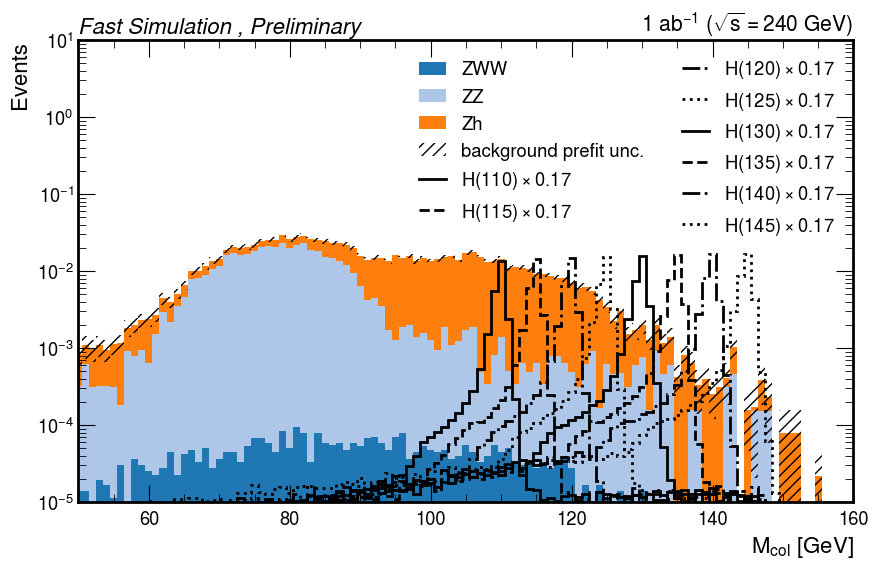

In [73]:
if CALCULATE_WEIGHTS:
    plot_target_histogram(
        signal=hist_signal,
        background=hist_backgrounds_x100,
        # histname='03_MET_dphi_m_collinear',
        histname=find_histogram_names(all_hist_lists, 'finalstate_nocut_m_collinear'),
        custom_parameters={
            'title': r'Fast Simulation',
            'xlabel': r'$M_{\text{col}}$ [GeV]',
            'ylabel': 'Events',
            'xlim' : (50, 160),
            'yscale': 'log',
            'ylim' : (1e-5, 1e1)
        },
        outdir="HLFV_paper",
        saveas_pdf=False,
        # save_name="collinear_mass_etaumu_prefit", # if CHANNEL == "etaumu"
        save_name="collinear_mass_mutaue_prefit" if CHANNEL == "mutaue" else "collinear_mass_etaumu_prefit",
        # save_name="reconstruected_mutaue" if CHANNEL == "mutaue" else "reconstruected_etaumu",  # For raw count
        figsize=(10,6)
    )

In [74]:
import numpy as np
from scipy.stats import poisson
from scipy.optimize import brentq

def upper_limit_xsec_br(signal_yield, background_yields, lumi_ab=1.0, CL=0.95):
    """
    Calculate the median expected 95% CL upper limit on sigma*BR for a single-bin counting experiment.
    
    Parameters
    ----------
    signal_yield : float
        Expected number of signal events at sigma*BR = 1 (for lumi_ab ab^-1)
    background_yields : list or array
        List of background yields (all in the same bin)
    lumi_ab : float, optional
        Target luminosity in ab^-1 (default = 1)
    CL : float, optional
        Confidence level for upper limit (default = 0.95)
        
    Returns
    -------
    s95 : float
        Upper limit on the number of signal events
    xsec_br_limit : float
        Upper limit on sigma*BR (relative to input signal normalization)
    """
    
    # multiply yield of signal and background by luminosity
    signal_yield *= lumi_ab
    background_yields = np.array(background_yields) * lumi_ab
    
    b = np.sum(background_yields)
    n_obs = int(round(b))  # median expected count under background-only

    def cdf_diff(s):
        # Compute the probability that Poisson(s+b) <= n_obs
        return poisson.cdf(n_obs, s + b) - (1 - CL)

    # Find s where the above equation = 0
    s95 = brentq(cdf_diff, 0, 10 * max(1, b + signal_yield))  # safe upper bound
    
    # Upper limit on sigma*BR (assuming input signal_yield corresponds to sigma*BR = 1)
    xsec_br_limit = s95 / signal_yield if signal_yield > 0 else np.inf
    
    return s95, xsec_br_limit

Cut: 0.11, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 0.27, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 0.43, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 0.59, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 0.75, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 0.91, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 1.07, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 1.23, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 1.39, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 1.55, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 1.70, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 1.86, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 2.02, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 2.18, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 2.34, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 2.50, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 2.66, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 2.82, Signal: 0, Background: 0, S/sqrt(B): 0.0000
Cut: 2.98,

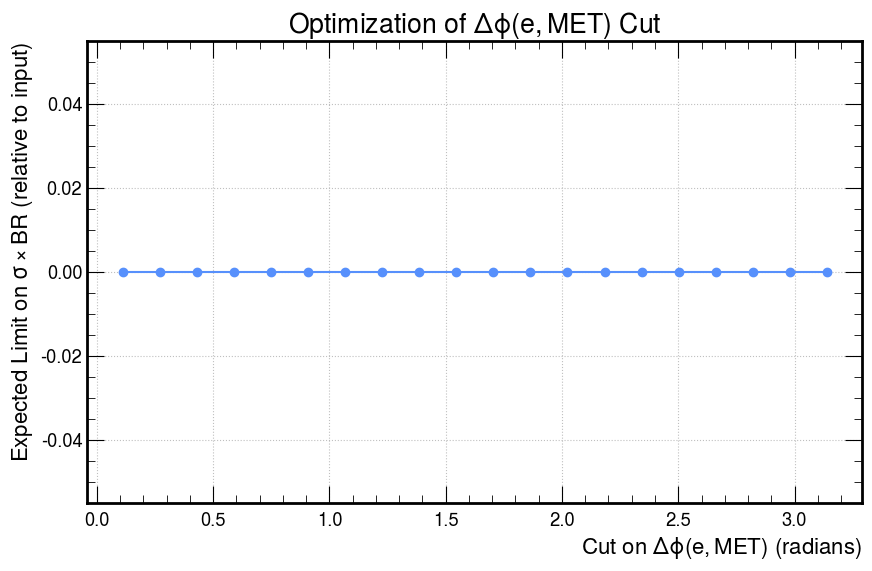

In [75]:
# Tets optimization by reading the histogram: 02_H_to_mue_h_e_pt
# Test run cut on dphi(e, MET) at varying values
# Calculate S/sqrt(B) for cut values from 0 to 3.14 radians
histname_to_optimize = '02_H_to_mue_dphi_e_met'
cut_values = np.linspace(0.11, 3.14, 20)
s_over_sqrt_b = []

for cut in cut_values:
    # Apply cut to background
    total_bkg = 0
    for bkg_proc, histograms in hist_backgrounds.items():
        hist = histograms.get(histname_to_optimize, None)
        if hist is None:
            continue
        # Sum events passing the cut
        tot_bkg_proc = 0
        for i in range(1, hist.GetNbinsX() + 1):
            bin_center = hist.GetXaxis().GetBinCenter(i)
            if bin_center <= cut:
                tot_bkg_proc += hist.GetBinContent(i)
        total_bkg += tot_bkg_proc
        print(f"\tBackground Process: {bkg_proc}, Events passing cut {cut:.2f}: {tot_bkg_proc}")

    # Apply cut to signal
    total_sig = 0
    for sig_proc, histograms in hist_signal.items():
        hist = histograms.get(histname_to_optimize, None)
        if hist is None:
            continue
        # Sum events passing the cut
        for i in range(1, hist.GetNbinsX() + 1):
            bin_center = hist.GetXaxis().GetBinCenter(i)
            if bin_center <= cut:
                total_sig += hist.GetBinContent(i)

    # Calculate S/sqrt(B)
    if total_bkg > 0:
        # s_sqrt_b = total_sig / np.sqrt(total_bkg)
        # SS = sqrt(2 * ((s + b) * log(1 + s/b) - s))
        s = total_sig
        b = total_bkg
        # s_sqrt_b = np.sqrt(2 * ((s + b) * np.log(1 + s / b) - s))
        # expected upper limit (with Higgs Combine HybridNew method)
        _ = upper_limit_xsec_br(total_sig, [total_bkg], lumi_ab=1.0, CL=0.95)
        s_sqrt_b = _[1]
        
    else:
        s_sqrt_b = 0
    s_over_sqrt_b.append(s_sqrt_b)
    print(f"Cut: {cut:.2f}, Signal: {total_sig}, Background: {total_bkg}, S/sqrt(B): {s_sqrt_b:.4f}")
    
# Plot S/sqrt(B) vs cut value
plt.figure(figsize=(10,6))
plt.plot(cut_values, s_over_sqrt_b, marker='o')
plt.xlabel(r'Cut on $\Delta\phi(e, \mathrm{MET})$ (radians)')
plt.ylabel(r'Expected Limit on $\sigma \times BR$ (relative to input)')
plt.title(r'Optimization of $\Delta\phi(e, \mathrm{MET})$ Cut')
plt.grid()
plt.show()

In [76]:
hist_backgrounds

{'Zh': {'00_Initial_dphi_e_met': <numpy_hist.NumpyHist1D at 0x31988f3d0>,
  '00_Initial_dphi_mu_e': <numpy_hist.NumpyHist1D at 0x319bf1f90>,
  '00_Initial_dphi_mu_met': <numpy_hist.NumpyHist1D at 0x320945bd0>,
  '00_Initial_h_e_pt': <numpy_hist.NumpyHist1D at 0x320945550>,
  '00_Initial_h_mu_pt': <numpy_hist.NumpyHist1D at 0x320945510>,
  '00_Initial_m_collinear': <numpy_hist.NumpyHist1D at 0x3209457d0>,
  '00_Initial_m_h1': <numpy_hist.NumpyHist1D at 0x3196e8650>,
  '00_Initial_m_h2': <numpy_hist.NumpyHist1D at 0x3196ea310>,
  '00_Initial_m_z1': <numpy_hist.NumpyHist1D at 0x3196eae50>,
  '00_Initial_m_z2': <numpy_hist.NumpyHist1D at 0x3196eaed0>,
  '00_Initial_n_muons': <numpy_hist.NumpyHist1D at 0x3196ebb90>,
  '00_Initial_z_mass': <numpy_hist.NumpyHist1D at 0x3196ea2d0>,
  '00_Initial_z_mass_diff': <numpy_hist.NumpyHist1D at 0x31969e050>,
  '01_lepton_selection_dphi_e_met': <numpy_hist.NumpyHist1D at 0x31969df50>,
  '01_lepton_selection_dphi_mu_e': <numpy_hist.NumpyHist1D at 0x31969

In [77]:
# ...existing code...
def plot_brazil_limits(data,
                       mass_width=2.0,
                       ax=None,
                       title=None,
                       xlabel='Mass (GeV)',
                       ylabel='Upper limit',
                       show=True,
                       color_median='black'):
    """
    Plot "Brazil" style limits from `data`.

    Input format:
      data = {
        'mass':  [125, 130, ...]  # or scalar 125
        'limits': [L125, L130, ...]  # each element can be:
             - dict with quantiles '0.5','0.84','0.16','0.975','0.025'
             - dict with keys 'median','up1','down1','up2','down2'
             - a numeric median
             - a tuple/list (median, down1, up1) or (median, down1, up1, down2, up2)
      }

    This implementation builds arrays at the mass centers and uses
    fill_between over the mass array so the ±1σ (green) and ±2σ (yellow)
    bands are connected/interpolated between mass points.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # normalize input
    if isinstance(data, dict) and 'mass' in data and 'limits' in data:
        masses = np.atleast_1d(data['mass']).astype(float)
        raw_limits = list(data['limits'])
    else:
        # allow direct single-limit dict/number
        masses = np.atleast_1d(125.0).astype(float)
        raw_limits = [data]

    # broadcast if needed
    if len(masses) != len(raw_limits):
        if len(masses) == 1 and len(raw_limits) > 1:
            masses = np.repeat(masses, len(raw_limits))
        elif len(raw_limits) == 1 and len(masses) > 1:
            raw_limits = raw_limits * len(masses)
        else:
            raise ValueError("Length of 'mass' and 'limits' must match (or one may be length 1).")

    def _standardize(entry):
        # returns dict with keys median, up1, down1, up2, down2 (None if absent)
        out = {'median': None, 'up1': None, 'down1': None, 'up2': None, 'down2': None}
        if entry is None:
            return out
        # numeric -> median only
        if isinstance(entry, (int, float, np.floating, np.integer)):
            out['median'] = float(entry)
            return out
        # list/tuple/ndarray
        if isinstance(entry, (list, tuple, np.ndarray)):
            arr = list(entry)
            if len(arr) == 1:
                out['median'] = float(arr[0])
            elif len(arr) == 3:
                out['median'] = float(arr[0]); out['down1'] = float(arr[1]); out['up1'] = float(arr[2])
            elif len(arr) >= 5:
                out['median'] = float(arr[0]); out['down1'] = float(arr[1]); out['up1'] = float(arr[2])
                out['down2'] = float(arr[3]); out['up2'] = float(arr[4])
            return out
        # dict-like
        if isinstance(entry, dict):
            # quantiles style
            if '0.5' in entry:
                out['median'] = float(entry.get('0.5'))
                out['up1'] = float(entry.get('0.84')) if '0.84' in entry else None
                out['down1'] = float(entry.get('0.16')) if '0.16' in entry else None
                out['up2'] = float(entry.get('0.975')) if '0.975' in entry else None
                out['down2'] = float(entry.get('0.025')) if '0.025' in entry else None
                return out
            # descriptive keys
            if 'median' in entry:
                out['median'] = float(entry.get('median'))
                out['up1'] = float(entry.get('up1')) if entry.get('up1') is not None else entry.get('+1', None)
                out['down1'] = float(entry.get('down1')) if entry.get('down1') is not None else entry.get('-1', None)
                out['up2'] = float(entry.get('up2')) if entry.get('up2') is not None else entry.get('+2', None)
                out['down2'] = float(entry.get('down2')) if entry.get('down2') is not None else entry.get('-2', None)
                return out
            # fallback: try find common keys
            for k, v in entry.items():
                lk = str(k).lower()
                try:
                    val = float(v)
                except Exception:
                    continue
                if 'med' in lk:
                    out['median'] = val
                if lk in ('up1', '+1', 'p1'):
                    out['up1'] = val
                if lk in ('down1', '-1', 'm1'):
                    out['down1'] = val
                if lk in ('up2', '+2', 'p2'):
                    out['up2'] = val
                if lk in ('down2', '-2', 'm2'):
                    out['down2'] = val
            return out
        return out

    std_limits = [_standardize(x) for x in raw_limits]

    # sort by mass to ensure monotonic x for fill_between
    order = np.argsort(masses)
    masses = masses[order]
    std_limits = [std_limits[i] for i in order]

    # build arrays at mass centers
    xs = np.array(masses)
    medians = np.array([L['median'] if L['median'] is not None else np.nan for L in std_limits], dtype=float)
    up1 = np.array([L['up1'] if L['up1'] is not None else np.nan for L in std_limits], dtype=float)
    down1 = np.array([L['down1'] if L['down1'] is not None else np.nan for L in std_limits], dtype=float)
    up2 = np.array([L['up2'] if L['up2'] is not None else np.nan for L in std_limits], dtype=float)
    down2 = np.array([L['down2'] if L['down2'] is not None else np.nan for L in std_limits], dtype=float)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # If only a single mass point: draw small horizontal bars with given mass_width
    if xs.size == 1:
        m = xs[0]
        x_left = m - mass_width
        x_right = m + mass_width
        if not np.isnan(up2) and not np.isnan(down2):
            ax.fill_between([x_left, x_right], [down2[0], down2[0]], [up2[0], up2[0]],
                            color='yellow', edgecolor='none', label=r'$\pm2\sigma$ (expected)', alpha=0.9)
        if not np.isnan(up1) and not np.isnan(down1):
            ax.fill_between([x_left, x_right], [down1[0], down1[0]], [up1[0], up1[0]],
                            color='green', edgecolor='none', label=r'$\pm1\sigma$ (expected)', alpha=0.9)
        if not np.isnan(medians[0]):
            ax.hlines(medians[0], x_left, x_right, colors=color_median, linewidth=2, label='median expected')
            ax.plot(m, medians[0], marker='o', color=color_median)
    else:
        # For multiple masses: connected bands via fill_between on mass centers.
        # Draw ±2σ first (behind), then ±1σ on top.
        if np.any(~np.isnan(up2)) and np.any(~np.isnan(down2)):
            ax.fill_between(xs, down2, up2, where=~(np.isnan(down2) | np.isnan(up2)),
                            color='yellow', edgecolor='none', label=r'$\pm2\sigma$ (expected)', alpha=0.9, interpolate=True)
        if np.any(~np.isnan(up1)) and np.any(~np.isnan(down1)):
            ax.fill_between(xs, down1, up1, where=~(np.isnan(down1) | np.isnan(up1)),
                            color='green', edgecolor='none', label=r'$\pm1\sigma$ (expected)', alpha=0.9, interpolate=True)
        # median line and points (plot points where median available)
        if not np.all(np.isnan(medians)):
            ax.plot(xs, medians, color=color_median, linestyle='-', linewidth=1, label='median expected')
            ax.plot(xs, medians, 'o', color=color_median)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title:
        # ax.set_title(title)
        title_text = title
    else:
        title_text = 'Expected Limits'
        title_text = ''
    
    # hep.cms.label(exp='FCC-ee', llabel=title_text + " , Preliminary", rlabel="1 ab$^{-1}$ ($\sqrt{s} = 240$ GeV)")
    hep.cms.label(exp='', llabel='Fast Simulation', rlabel="1 ab$^{-1}$ ($\sqrt{s} = 240$ GeV)")
    # Work irrevalent to the Collaboration, private work

    xmin = float(np.min(xs) - mass_width * 2)
    xmax = float(np.max(xs) + mass_width * 2)
    ax.set_xlim(xmin, xmax)

    # sensible y-limits from available numbers
    yvals = []
    for Larr in (medians, up1, up2, down1, down2):
        mask = ~np.isnan(Larr)
        if np.any(mask):
            yvals.extend(Larr[mask].tolist())
    if yvals:
        ymin = min(yvals) * 0.9
        ymax = max(yvals) * 1.1
        if ymin == ymax:
            ymin *= 0.5; ymax *= 1.5
        ax.set_ylim(ymin, ymax)

    ax.legend(loc='best')
    ax.grid(alpha=0.3)

    if show:
        plt.show()
    return ax


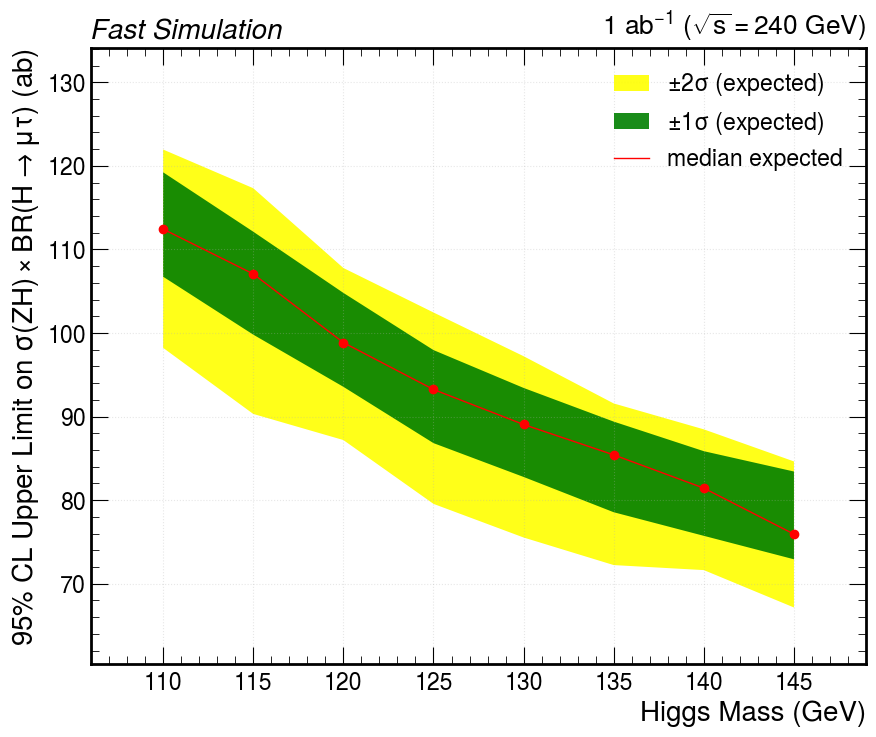

In [78]:
# Load limit from limits.json 
'''
format 
{
  "HMuTauE_LFV_110": {
    "0.025": 13.7493,
    "0.16": 15.3163,
    "0.5": 15.7965,
    "0.84": 16.8996,
    "0.975": 17.3984,
    "mass": 110
  },
  "HMuTauE_LFV_115": {
    "0.025": 12.7225,
    "0.16": 13.4701,
    "0.5": 14.9362,
    "0.84": 15.8429,
    "0.975": 16.1715,
    "mass": 115
  },
  ...

'''

# Set global text size for the matplotlib plots

plt.rcParams.update({'font.size':20})

import json
with open("datacards_mutaue/limits.json", "r") as f:
# with open("datacards_mutaue_offshell/limits.json", "r") as f:
# with open("limits.json", "r") as f:
    limit_data = json.load(f)
in_dict = {
    'mass': [],
    'limits': []
}
blacklist_masses = [150, 155, 160]  # Exclude these masses # Z offshell, really bad limits
scale_factor = 1/0.17
use_blacklist = True
for key in sorted(limit_data.keys()):
    entry = limit_data[key]
    mass = entry.get('mass', None)
    if mass in blacklist_masses and use_blacklist: continue
    if mass is None: continue
    in_dict['mass'].append(float(mass))
    limits_entry = {
        '0.025': entry.get('0.025', None),
        '0.16': entry.get('0.16', None),
        '0.5': entry.get('0.5', None),
        '0.84': entry.get('0.84', None),
        '0.975': entry.get('0.975', None),
    }
    limits_entry = {k: v * scale_factor if v is not None else None for k, v in limits_entry.items()}
    in_dict['limits'].append(limits_entry)
ax = plot_brazil_limits(
    data=in_dict,
    mass_width=2.0,
    # title=r'Expected 95% CL Upper Limits',
    xlabel='Higgs Mass (GeV)',
    # Cross-section times branching ratio
    # ylabel=r'95% CL Upper Limit on $\mathrm{BR}(H\to\mu\tau_e)$ (ab)',
    ylabel=r'95% CL Upper Limit on $\sigma(ZH)\times \mathrm{BR}(H\to\mu\tau)$ (ab)',
    show=False,
    color_median='red'
)

# Save figure to directory ./HLFV_paper/limit_plots_mutaue.pdf
output_dir = "HLFV_paper"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, "limit_plots_mutaue.pdf")
plt.savefig(output_path)
plt.show()

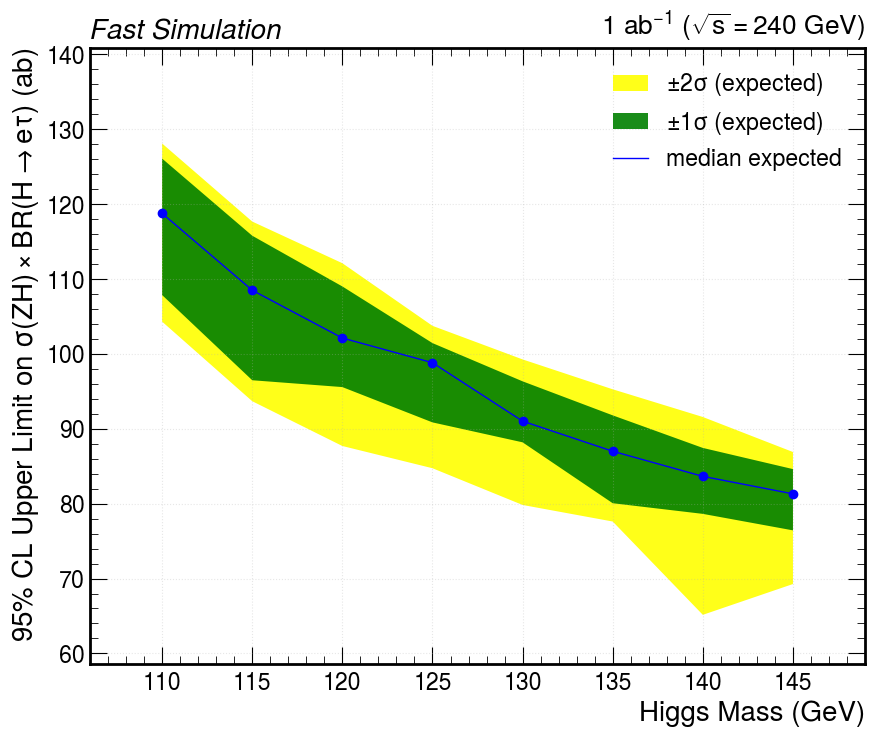

In [79]:
# Etau mu in the directory datacards_etaumu/limits.json
with open("datacards_etaumu/limits.json", "r") as f:
# with open("datacards_etaumu_offshell/limits.json", "r") as f:
    limit_data_etau = json.load(f)
in_dict_etau = {
    'mass': [],
    'limits': []
}
blacklist_masses = [150, 155, 160]  # Exclude these masses # Z offshell, really bad limits
use_blacklist = True
for key in sorted(limit_data_etau.keys()):
    entry = limit_data_etau[key]
    mass = entry.get('mass', None)
    if mass in blacklist_masses and use_blacklist: continue
    if mass is None: continue
    in_dict_etau['mass'].append(float(mass))
    limits_entry = {
        '0.025': entry.get('0.025', None),
        '0.16': entry.get('0.16', None),
        '0.5': entry.get('0.5', None),
        '0.84': entry.get('0.84', None),
        '0.975': entry.get('0.975', None),
    }
    limits_entry = {k: v * scale_factor if v is not None else None for k, v in limits_entry.items()}
    in_dict_etau['limits'].append(limits_entry)
ax = plot_brazil_limits(
    data=in_dict_etau,
    mass_width=2.0,
    # title=r'Expected 95% CL Upper Limits',
    xlabel='Higgs Mass (GeV)',
    # Cross-section times branching ratio
    # ylabel=r'95% CL Upper Limit on $\mathrm{BR}(H\to e\tau_\mu)$ (ab)',
    ylabel=r'95% CL Upper Limit on $\sigma(ZH)\times \mathrm{BR}(H\to e\tau)$ (ab)',
    show=False,
    color_median='blue'
)

# Save figure to directory ./HLFV_paper/limit_plots_etaumu.pdf
output_dir = "HLFV_paper"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, "limit_plots_etaumu.pdf")
plt.savefig(output_path)
plt.show()


In [80]:
# Test read ./test_sig.root and plot 2d histogram of 
# '<N>_H_to_mutau_e_m_h1 vs <N>_H_to_mutau_e_m_z1'
# test_sig = load_histograms_from_file("./test_sig.root")
signame = 'signal_HMuTauE_LFV_160'
# signame = 'background_ZWW'
mass = signame.split('_')[-1]
if mass.isdigit():
    mass = int(mass)
else: 
    mass = -1
# signame = 'background_HZFourLepton'
filename = f'{signame}.root'
test_sig = read_root_histograms(outdir='./outputs/relaxed_zcuts/mutaue_hist', pattern=filename)

# Construct all_hist_lists
all_hist_lists = []
# For each key in test_sig[signame], append to all_hist_lists
for hist_name in test_sig[signame].keys():
    all_hist_lists.append(hist_name)

# Construct he name of histogram
cut_name = 'H_to_mutau_e' # or finalstate_nocut
variable_1 = 'mZ_vs_mH1'
variable_2 = 'mZ2_vs_mH2'
name_hist1 = find_histogram_names(all_hist_lists, f'{cut_name}_{variable_1}')
name_hist2 = find_histogram_names(all_hist_lists, f'{cut_name}_{variable_2}')


DEBUG
Found 1 ROOT files matching pattern 'signal_HMuTauE_LFV_160.root' in './outputs/relaxed_zcuts/mutaue_hist'.
./outputs/relaxed_zcuts/mutaue_hist/signal_HMuTauE_LFV_160.root


Error in <THashList::Delete>: A list is accessing an object (0x106839f30) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x17fb77ee0) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x17fb764a0) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x17fb73390) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x17fb3c420) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x17fb3c810) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x106f5f7e0) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x17fb4c6b0) already deleted (list name = THashList)
Error in <THashList::Delete>: A list is accessing an object (0x10683a5c0) already delete

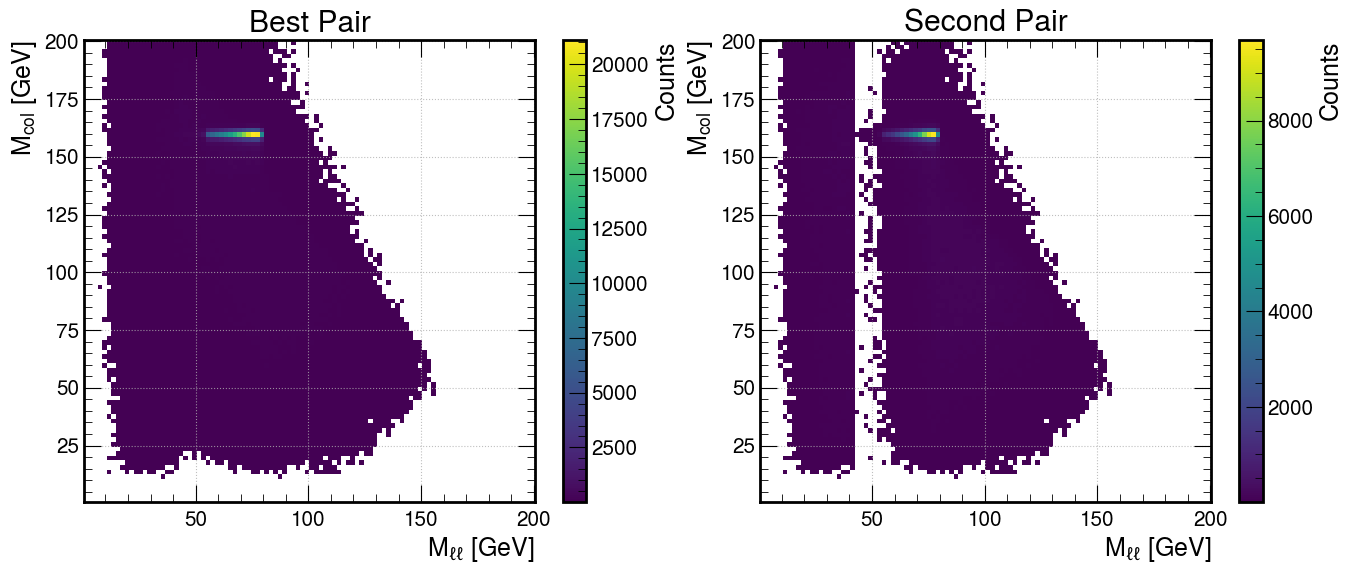

/var/folders/fb/q9sjts313pd_r3_jt75ytc100000gn/T/ipykernel_17641/2161443724.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


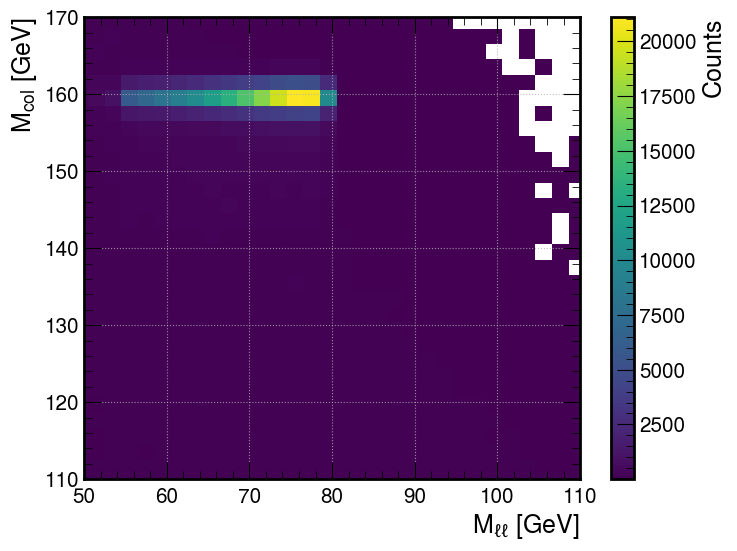

/var/folders/fb/q9sjts313pd_r3_jt75ytc100000gn/T/ipykernel_17641/2161443724.py:125: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


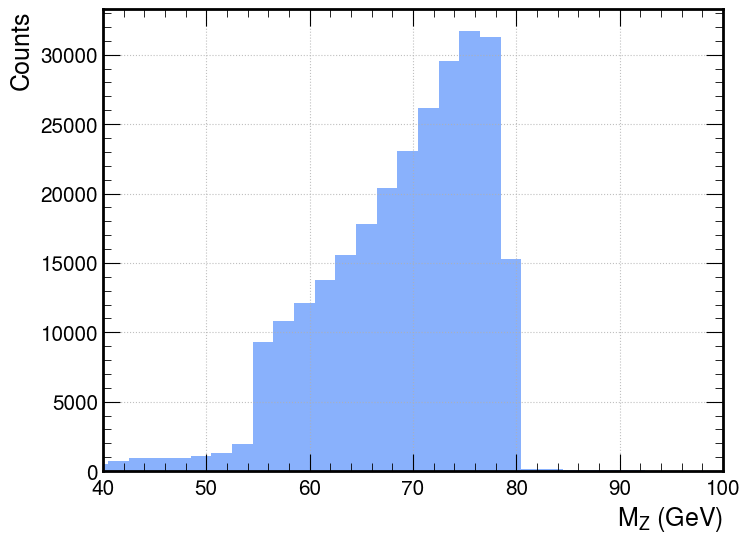

In [81]:
# hist_backgrounds['HZFourLepton']['05_finalstate_nocut_mZ2_vs_mH2'].GetBinContent(1, 1)

# Set global text size for matplotlib
plt.rcParams.update({'font.size': 18})

# Plot 2d hist
# Get all contents in the 2d histogram and plot using matplotlib
# target_2dhist = test_sig[signame]['05_finalstate_nocut_mZ_vs_mH1'].Clone()
# target_2dhist2 = test_sig[signame]['05_finalstate_nocut_mZ2_vs_mH2'].Clone()
target_2dhist = test_sig[signame][name_hist1].Clone()
target_2dhist2 = test_sig[signame][name_hist2].Clone()

target_mass = mass 
window_mass = 5

# Rebin all by factor of 2
# target_2dhist = rebinning_histogram(target_2dhist, rebin_factor=(2, 2))
# target_2dhist2 = rebinning_histogram(target_2dhist2, rebin_factor=(2, 2))

# Get all bin contents, by creating a 2D numpy array
nx = target_2dhist.GetNbinsX()
ny = target_2dhist.GetNbinsY()
bin_contents = np.zeros((nx, ny))
for ix in range(1, nx + 1):
    for iy in range(1, ny + 1):
        # bin_contents[ix - 1, iy - 1] = target_2dhist.GetBinContent(ix, iy) + target_2dhist2.GetBinContent(ix, iy)
        # If bin zero, set nan
        bin_content = target_2dhist.GetBinContent(ix, iy) + target_2dhist2.GetBinContent(ix, iy)
        if bin_content > 0:
            bin_contents[ix - 1, iy - 1] = bin_content
        else:
            bin_contents[ix - 1, iy - 1] = np.nan
# Get bin edges
x_edges = [target_2dhist.GetXaxis().GetBinLowEdge(i) for i in range(1, nx + 2)]
y_edges = [target_2dhist.GetYaxis().GetBinLowEdge(i) for i in range(1, ny + 2)]
# Plot using matplotlib

# 2D histogram of best pair and second pair on different subplots
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(bin_contents.T, origin='lower', aspect='auto',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel(r'$M_{\ell\ell}$ [GeV]')
plt.ylabel(r'$M_{col}$ [GeV]')
plt.title('Best Pair')
plt.grid()

plt.subplot(1, 2, 2)
# Create bin contents for second pair
bin_contents2 = np.zeros((nx, ny))
for ix in range(1, nx + 1):
    for iy in range(1, ny + 1):
        bin_content = target_2dhist2.GetBinContent(ix, iy)
        if bin_content > 0:
            bin_contents2[ix - 1, iy - 1] = bin_content
        else:
            bin_contents2[ix - 1, iy - 1] = np.nan
plt.imshow(bin_contents2.T, origin='lower', aspect='auto',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel(r'$M_{\ell\ell}$ [GeV]')
plt.ylabel(r'$M_{col}$ [GeV]')
plt.title('Second Pair')
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
# plt.title('Combined')
plt.hist2d([], [], bins=[x_edges, y_edges], weights=[], cmin=1)
plt.imshow(bin_contents.T, origin='lower', aspect='auto',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel(r'$M_{\ell\ell}$ [GeV]')
plt.ylabel(r'$M_{col}$ [GeV]')
plt.grid()
# Horizontal lines for target mass ± window
# if target_mass > 0:
#     plt.axhline(target_mass - window_mass, color='r', linestyle='--', label=f'{target_mass} ± {window_mass} GeV')
#     plt.axhline(target_mass + window_mass, color='r', linestyle='--')
plt.legend()
plt.xlim(50, 110)
plt.ylim(110, 170)

# save to directory plot_pdf/ with filename f'{signame}_2dhist.pdf'
plt.savefig(f'HLFV_paper/{signame}_2dhist.pdf')

plt.show()

# Construct pd.DataFrame from 2D histogram
import pandas as pd
data = []
for ix in range(1, nx + 1):
    for iy in range(1, ny + 1):
        bin_content = target_2dhist.GetBinContent(ix, iy) + target_2dhist2.GetBinContent(ix, iy)
        if bin_content > 0:
            x_center = target_2dhist.GetXaxis().GetBinCenter(ix)
            y_center = target_2dhist.GetYaxis().GetBinCenter(iy)
            data.append({'mZ2': x_center, 'mH2': y_center, 'counts': bin_content})
df_2d = pd.DataFrame(data)


df_filtered = df_2d[(df_2d['mH2'] >= target_mass - window_mass) & (df_2d['mH2'] <= target_mass + window_mass)]

# Plot 1 D histogram of Z using bin edge and count
plt.figure(figsize=(8, 6))
plt.hist(df_filtered['mZ2'], bins=x_edges, weights=df_filtered['counts'], histtype='stepfilled', alpha=0.7)
plt.xlabel(r'$M_{Z}$ (GeV)')
plt.ylabel('Counts')

# Draw quantile lines at 16%, 50%, 84%
total_counts = df_filtered['counts'].sum()
cumulative_counts = df_filtered.sort_values('mZ2')['counts'].cumsum()
quantiles = [0.16, 0.5, 0.84]
quantile_values = {}
# for q in quantiles:
#     threshold = q * total_counts
#     quantile_row = cumulative_counts[cumulative_counts >= threshold].iloc[0]
#     quantile_mZ2 = df_filtered.loc[cumulative_counts == quantile_row, 'mZ2'].values[0]
#     quantile_values[q] = quantile_mZ2
#     plt.axvline(quantile_mZ2, color='r', linestyle='--', label=f'{int(q*100)}% Quantile: {quantile_mZ2:.2f} GeV')
plt.legend()
plt.grid()
plt.xlim(40, 100)

# save to directory plot_pdf/ with filename f'{signame}_mZ2_hist.pdf'
plt.savefig(f'HLFV_paper/{signame}_mZ2_hist.pdf')

plt.show()





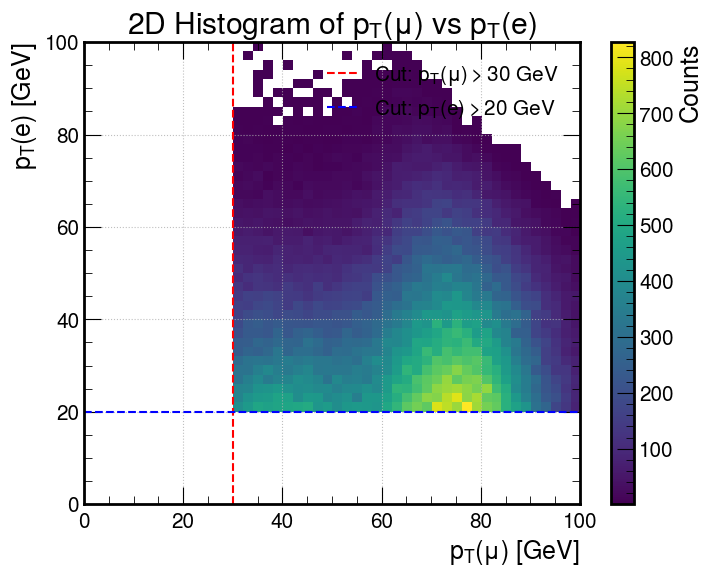

In [82]:
# Plot the '05_finalstate_nocut_pt_mu_vs_pt_e' 2D histogram
hist_2d = test_sig[signame]['05_finalstate_nocut_pt_mu_vs_pt_e'].Clone()
plt.figure(figsize=(8, 6))
nx = hist_2d.GetNbinsX()
ny = hist_2d.GetNbinsY()
bin_contents = np.zeros((nx, ny))
for ix in range(1, nx + 1):
    for iy in range(1, ny + 1):
        # bin_contents[ix - 1, iy - 1] = hist_2d.GetBinContent(ix, iy)
        # if bin is zero, set nan
        bin_content = hist_2d.GetBinContent(ix, iy)
        if bin_content > 0:
            bin_contents[ix - 1, iy - 1] = bin_content
        else:
            bin_contents[ix - 1, iy - 1] = np.nan
x_edges = [hist_2d.GetXaxis().GetBinLowEdge(i) for i in range(1, nx + 2)]
y_edges = [hist_2d.GetYaxis().GetBinLowEdge(i) for i in range(1, ny + 2)]
plt.imshow(bin_contents.T, origin='lower', aspect='auto',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel(r'$p_{T}(\mu)$ [GeV]')
plt.ylabel(r'$p_{T}(e)$ [GeV]')
plt.title('2D Histogram of $p_{T}(\mu)$ vs $p_{T}(e)$')

# Line for current cut at 30 GeV for muon and 20 GeV for electron
plt.axvline(30, color='r', linestyle='--', label='Cut: $p_{T}(\mu) > 30$ GeV')
plt.axhline(20, color='b', linestyle='--', label='Cut: $p_{T}(e) > 20$ GeV')
plt.legend()

plt.grid()
plt.show()

In [83]:
import math

# --- constants (PDG-like)
G_F = 1.1663787e-5            # GeV^-2
mZ  = 91.1876                 # GeV
mH  = 125.0                   # GeV
sin2 = 0.23126                # sin^2 theta_W (on-shell-like)
sqrt_s = 240.0                # GeV (change if needed)
s = sqrt_s**2

# electron couplings
ae = -0.5
ve = -0.5 + 2.0*sin2   # v_e = T3 - 2 Q sin^2 theta_W, Q_e = -1

# Kallen lambda
lam = (1 - (mH**2 + mZ**2)/s)**2 - 4*(mH**2)*(mZ**2)/s**2
if lam < 0:
    lam = 0.0
beta = math.sqrt(lam)

# tree-level cross section (GeV^-2)
pref = (G_F**2 * mZ**4) / (96.0 * math.pi * s)
factor = (ve**2 + ae**2) * beta * (lam + 12.0*(mZ**2)/s) / ((1.0 - mZ**2/s)**2)
sigma_GeV2 = pref * factor

# convert 1 GeV^-2 -> pb: (hbar*c)^2 / 1e-36 with hbar*c = 0.1973269804e-15 GeV*m
hbarc = 0.1973269804e-15
conv = (hbarc**2) / 1e-36   # ~ 3.8937937e4 pb per GeV^-2
sigma_pb = sigma_GeV2 * conv

print(f"sqrt(s) = {sqrt_s} GeV")
print(f"tree-level sigma(e+e- -> ZH) = {sigma_pb:.6g} pb")

# Convert to fb
sigma_fb = sigma_pb * 1e3
print(f"tree-level sigma(e+e- -> ZH) = {sigma_fb:.6g} fb")

sqrt(s) = 240.0 GeV
tree-level sigma(e+e- -> ZH) = 5.96781e-06 pb
tree-level sigma(e+e- -> ZH) = 0.00596781 fb


In [84]:
0.24e3

240.0